In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import pickle
import json
import tqdm
from tqdm import tqdm
from tensorflow.keras.models import model_from_json
from LSTNet.lstnet_util import GetArguments, LSTNetInit
from LSTNet.lstnet_model import PreSkipTrans, PostSkipTrans, PreARTrans, PostARTrans, LSTNetModel, ModelCompile
import subprocess
import yfinance as yf
import pandas as pd

class FetchStocks():
    def __init__(self,
                 period="1000d",
                 tickers=['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'JPM', 'V', 'JNJ', 'PG', 'XOM', 'T', 'BAC', 'WMT', 'INTC', 'PFE',
           'VZ', 'KO', 'TSLA', 'MRK', 'DIS', 'UNH', 'HD', 'ADBE', 'CMCSA', 'PEP', 'CSCO', 'NVDA', 'NFLX',
           'ABT', 'NKE', 'CVX', 'ACN', 'TMUS', 'BMY', 'LLY', 'TMO', 'IBM', 'MCD', 'ORCL', 'UPS', 'MDT', 'COST',
           'PM', 'AVGO', 'SAP', 'HON', 'NEE', 'TXN', 'MO'],
           save_files=True
           ):
        self.csv_path="LSTNet\data\large_portfolio.csv"
        self.txt_path="LSTNet\data\large_portfolio.txt"
        self.tickers=tickers
        self.period=period
        self.downloaded_data = yf.download(self.tickers, period=self.period,group_by='ticker', auto_adjust=True)
        open_prices = pd.DataFrame({ticker: self.downloaded_data[ticker]['Open'] for ticker in self.tickers})
        self.df=open_prices
        if save_files==True :
            open_prices.to_csv("LSTNet\data\large_portfolio.csv")
            np.savetxt("LSTNet\data\large_portfolio.txt", np.array(open_prices), delimiter=',')



class LSTNetModel(FetchStocks):
    def __init__ (self,
                data_path="data\large_portfolio.txt",
                horizon=1,
                save_name="large_portfolio",
                window=7,
                validpercent=0.40,
                batchsize=16,
                skip=7,
                epochs=100,
                cnn_kernel=6,
                learning_rate=0.001,
                dropout=0.2,
                highway=7,
                GRUUnits=100,
                SkipGRUUnits=5,
    ):
        super().__init__()
        self.data_path=data_path
        self.horizon=horizon
        self.save_name=save_name
        self.window=window
        self.validpercent=validpercent
        self.batchsize=batchsize
        self.skip=skip
        self.epochs=epochs
        self.cnn_kernel=cnn_kernel
        self.learning_rate=learning_rate
        self.dropout=dropout
        self.highway=highway
        self.GRUUnits=GRUUnits
        self.SkipGRUUnits=SkipGRUUnits
    
    def train_model(self):
        print("training...")
        os.chdir("LSTNet")
        command = f'python main.py --data={self.data_path} --horizon={self.horizon} --save="save/{self.save_name}_horizon{self.horizon}_window{self.window}_skip{self.skip}" --test --savehistory --logfilename="log/lstnet" --debuglevel=20 --predict="all" --plot --save-plot="save/{self.save_name}_horizon{self.horizon}_window{self.window}_skip{self.skip}_plots" --window={self.window} --validpercent={self.validpercent} --batchsize={self.batchsize} --skip={self.skip} --epochs={self.epochs} --CNNKernel={self.cnn_kernel} --lr={self.learning_rate} --dropout={self.dropout} --highway={self.highway} --GRUUnits={self.GRUUnits} --SkipGRUUnits={self.SkipGRUUnits}' 
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
        output, error = process.communicate()

        if process.returncode == 0:
            print(output.decode())
        else:
            print("Error:", error.decode())
        print("model saved")
        print(f'Outputs can be found at: LSTNet/save/{self.save_name}_horizon{self.horizon}_window{self.window}_skip{self.skip}')
    
    def get_trained_model(self):
        custom_objects = {"PreSkipTrans": PreSkipTrans,
                  "PostSkipTrans": PostSkipTrans,
                  "PreARTrans": PreARTrans,
                  "PostARTrans": PostARTrans,
                  }

        json_file = open(f'save\{self.save_name}_horizon{self.horizon}_window{self.window}_skip{self.skip}.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()

        loaded_model = model_from_json(loaded_model_json, custom_objects=custom_objects)
        loaded_model.load_weights(f'save\{self.save_name}_horizon{self.horizon}_window{self.window}_skip{self.skip}.h5')

        model = loaded_model
        return model

class LSTNetIteratedModel(LSTNetModel, FetchStocks):
    def __init__(self,
                 forecast_steps,
                 n_series,
                 csv_path,
                 save_forecast_json=True
                 ):
        super().__init__()
        self.forecast_steps=forecast_steps
        self.timesteps=self.window
        self.series=np.array(pd.read_csv(csv_path))[:,1:]
        self.json=save_forecast_json
 
    def get_forecast(self):
        model=self.get_trained_model()
        series=self.series
        time_steps=self.window
        forecast_steps=self.forecast_steps
        last_batch=series[-time_steps:,:]
        forecast=[]
        for step in range(forecast_steps):
            pred=model.predict(np.array(last_batch, dtype='float32').reshape(1,time_steps,series.shape[1]))
            forecast.append(pred)
            last_batch=np.append(last_batch[1:,:],pred, axis=0)
        forecast=np.array(forecast)
        
        return forecast

    def plot_lstnet_forecast(self, series_index=24):
        model=self.get_trained_model()
        series=self.series
        time_steps=self.window
        forecast=self.get_forecast()
        forecast_df=pd.DataFrame(forecast.reshape(self.forecast_steps,series.shape[1]))
        forecast_df.columns=self.tickers 

        series_df=pd.DataFrame(series)
        series_df.columns=self.tickers
        cumulative_df=pd.concat([series_df,forecast_df], axis=0)
        cumulative_df=pd.DataFrame(np.array(cumulative_df))
        cumulative_df.iloc[-(100+len(forecast_df)):-len(forecast_df),series_index].plot(color='blue')
        cumulative_df.iloc[-len(forecast_df):,series_index].plot(color='red')
        output_df=cumulative_df.iloc[-55:,:]
    
        if self.json==True:
            json_data = output_df.to_json(orient='index')

            with open('LargePortfolioLSTNet_forecast.json', 'w') as f:
                f.write(json_data)
            print('JSON data saved to', 'LargePortfolioLSTNet_forecast.json')

        plt.legend()
        title_ticker=self.tickers[series_index]
        plt.title(title_ticker)
        plt.show()



In [2]:
fetcher=FetchStocks()

[*********************100%***********************]  48 of 48 completed


In [3]:
fetcher.df

,AAPL,GOOGL,AMZN,MSFT,JPM,V,JNJ,PG,XOM,T,...,UPS,MDT,COST,PM,AVGO,SAP,HON,NEE,TXN,MO
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-02,49.852464,60.150002,92.253502,132.726069,99.535635,173.290134,117.616369,105.537941,58.500793,18.548447,...,103.342073,92.191289,259.157653,66.082457,245.881555,113.594180,155.755031,48.490001,111.197934,35.109502
2019-08-05,48.023592,58.648499,88.511002,128.122143,98.109903,167.458644,117.661317,105.157497,57.026381,18.493569,...,102.305576,90.646057,255.180009,66.777622,237.059915,111.230912,152.333540,48.591060,107.614372,34.628748
2019-08-06,47.616106,58.276001,89.611504,128.602686,97.454601,167.244454,117.148988,102.947291,56.631598,18.389298,...,102.420742,90.365907,251.759912,64.819942,235.473411,109.303241,150.664314,47.805551,106.838097,34.169856
2019-08-07,47.397804,57.889999,88.699501,128.593049,95.639237,166.962145,116.268176,103.037848,56.285174,18.438689,...,100.675463,90.691226,253.375474,64.212641,230.156007,110.294881,150.286219,48.552020,105.872251,33.441438
2019-08-08,48.559644,59.321499,90.300003,131.293939,96.569054,172.764437,117.724224,104.641170,57.082782,18.795390,...,103.244612,91.748518,257.967183,65.067629,235.691328,111.944533,151.789421,48.972323,110.105700,33.667246
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-18,193.350006,124.599998,132.710007,345.829987,153.380005,243.100006,159.070007,147.709328,100.919998,13.530000,...,182.820007,86.129997,552.669983,98.620003,905.979980,144.380005,206.699997,72.769997,182.440002,45.400002
2023-07-19,193.100006,124.599998,133.389999,361.750000,152.750000,241.250000,157.910004,148.613642,101.050003,14.320000,...,184.600006,86.349998,554.479980,98.010002,897.270020,143.630005,203.850006,72.360001,183.589996,45.599998
2023-07-20,195.089996,121.419998,134.070007,353.570007,154.529999,241.160004,161.940002,149.550003,102.540001,14.590000,...,186.630005,87.250000,553.809998,99.779999,892.539978,140.860001,206.149994,72.099998,180.649994,45.689999


In [4]:
csv_path=fetcher.csv_path
lstnet_iterated=LSTNetIteratedModel(n_series=48,forecast_steps=15, csv_path=csv_path)

[*********************100%***********************]  48 of 48 completed


In [5]:
lstnet_iterated.train_model()

training...
Epoch 1/100

38/38 [==============================] - 7s 35ms/step - loss: 0.5226 - rse: 3.4873 - corr: nan - val_loss: 0.2490 - val_rse: 2.3105 - val_corr: 0.2228
Epoch 2/100

38/38 [==============================] - 0s 9ms/step - loss: 0.2194 - rse: 1.5185 - corr: nan - val_loss: 0.2112 - val_rse: 1.8736 - val_corr: 0.2294
Epoch 3/100

38/38 [==============================] - 0s 9ms/step - loss: 0.1609 - rse: 1.1119 - corr: nan - val_loss: 0.1922 - val_rse: 1.7615 - val_corr: 0.2155
Epoch 4/100

38/38 [==============================] - 0s 9ms/step - loss: 0.1197 - rse: 0.8257 - corr: nan - val_loss: 0.1843 - val_rse: 1.6110 - val_corr: 0.2112
Epoch 5/100

38/38 [==============================] - 0s 9ms/step - loss: 0.1064 - rse: 0.7204 - corr: nan - val_loss: 0.2319 - val_rse: 1.9087 - val_corr: 0.2141
Epoch 6/100

38/38 [==============================] - 0s 9ms/step - loss: 0.1003 - rse: 0.6875 - corr: nan - val_loss: 0.1626 - val_rse: 1.4038 - val_corr: 0.2109
Epoch 7/1

In [6]:
forecast=lstnet_iterated.get_forecast()

1/1 [==============================] - 0s 35ms/step


In [7]:
pd.DataFrame(forecast.reshape(15,48))

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,194.071411,125.847145,134.358444,345.735687,153.135803,244.960190,162.820389,150.208755,102.269943,14.121084,...,185.200714,87.612648,552.511475,99.706757,902.465698,143.195236,208.482407,73.994469,182.703857,45.711899
1,194.638016,126.971901,135.046936,354.853821,153.625488,245.671051,158.124191,148.793228,101.351631,13.822315,...,185.010757,86.974686,556.366211,99.637421,910.549011,147.304016,207.261978,72.986893,183.773956,45.877590
2,195.604523,124.765602,134.778625,361.916748,154.775803,243.557465,159.978775,149.918945,102.195305,14.399155,...,186.533737,87.051430,559.325562,99.451187,904.900452,144.661819,206.378510,72.742111,184.396133,46.014328
3,196.449768,122.343315,134.495346,357.513397,156.202576,242.698853,164.594406,151.216263,103.817947,14.744738,...,188.417633,88.695679,560.644897,100.184402,903.905396,140.874863,208.185638,73.279297,182.792557,46.100967
4,195.790924,121.463997,132.152954,351.117645,157.112625,241.508972,171.154663,153.143753,105.305466,14.860121,...,188.483078,90.336082,563.760498,99.184296,909.942261,135.684906,210.266663,75.446655,184.149750,46.041008
5,195.254883,123.670815,132.410080,347.891754,155.955170,243.139771,171.225525,153.566788,104.887054,14.725681,...,187.436630,89.748123,561.577759,99.010361,909.837158,136.844620,210.735809,76.172478,185.485931,46.001686
6,195.755188,127.248161,135.360306,350.569336,154.600571,247.102234,163.695709,151.376221,103.015671,14.164936,...,186.616989,88.264984,558.613403,100.326736,912.922607,144.933105,210.096237,74.650093,184.939667,46.129829
7,196.581573,127.930374,136.463165,359.690796,154.997375,247.689911,159.314423,150.220276,102.247192,14.041058,...,186.878464,87.536713,561.279907,100.580437,916.562622,148.641205,208.760437,73.436989,185.491257,46.310356
8,197.616516,125.529594,136.186203,364.624420,156.418808,245.814545,161.579132,151.233414,103.286041,14.534239,...,188.587479,88.083084,564.464172,100.646980,913.240295,145.884857,208.509155,73.273705,185.474792,46.452160
9,198.065369,122.985397,134.979446,360.081390,157.934097,244.248596,167.725082,153.063782,105.143326,14.931171,...,190.173935,89.875526,566.874023,100.719048,913.320923,140.595322,210.367340,74.422668,184.869263,46.496590


1/1 [==============================] - 0s 29ms/step
JSON data saved to LargePortfolioLSTNet_forecast.json


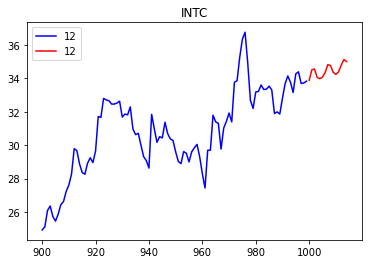

In [10]:
lstnet_iterated.plot_lstnet_forecast(series_index=12)

In [ ]:
'LSTNet\\save\\large_portfolio_horizon1_window28_skip7.json'

'LSTNet\\save\\large_portfolio_horizon1_window28_skip7.json'